In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pyodbc 
import warnings
warnings.filterwarnings("ignore")

# --------------------
# 1. Connexion SQL Server
# --------------------
server = 'DESKTOP-OQHAOET'       # e.g. 'localhost\\SQLEXPRESS' or '192.168.1.10'
database = 'DW_supplyChain'   # e.g. 'CosmeticDB'
username = 'sa'        # optional if using trusted connection
password = 'lina123'        # optional if using trusted connection

# Trusted Connection (Windows Authentication)
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={sa};PWD={lina123}'

conn = pyodbc.connect(conn_str)




# 1. Connexion SQL Server
server = 'DESKTOP-OQHAOET'
database = 'DW_supplyChain'
username = 'sa'
password = 'lina123'

conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

conn = pyodbc.connect(conn_str)








# 2. Charger les données
query = """
SELECT 
    productREF,
    productname,
    brandname,
    unitprice,
    materialname,
    materialcategory,
    quantityused,
    manufacturedate,
    expirydate,
    category
FROM Dim_Product
"""
df = pd.read_sql(query, conn)

# 3. Nettoyage et transformation
df['manufacturedate'] = pd.to_datetime(df['manufacturedate'])
df['expirydate'] = pd.to_datetime(df['expirydate'])
df['product_lifetime_days'] = (df['expirydate'] - df['manufacturedate']).dt.days

# 🔧 Conversion de quantityused en numérique
df['quantityused'] = pd.to_numeric(df['quantityused'], errors='coerce')
df['quantityused'].fillna(df['quantityused'].median(), inplace=True)





# 4. Sélection des features
features = ['productREF', 'productname', 'brandname', 'unitprice',
            'materialname', 'materialcategory', 'quantityused', 'product_lifetime_days']
X = df[features]
y = df['category']

# 5. Encodage des variables catégorielles
label_encoders = {}
for col in ['productREF', 'productname', 'brandname', 'materialname', 'materialcategory']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # conversion explicite
    label_encoders[col] = le

# 6. Encodage de la cible
le_category = LabelEncoder()
y_encoded = le_category.fit_transform(y.astype(str))

# 7. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 8. SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ✅ Vérification des types (important)
X_train_res = X_train_res.apply(pd.to_numeric)

# 9. XGBoost
xgb = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [20],
    'max_depth': [2],
    'learning_rate': [0.6],
    'subsample': [0.3],
    'colsample_bytree': [0.3]
}

# 10. Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# 11. Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 12. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 13. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.show()



NameError: name 'sa' is not defined

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Meilleure précision CV : 0.6689138576779026

Accuracy: 0.6409

Classification Report:
              precision    recall  f1-score   support

    Bodycare       0.66      0.58      0.62       200
   Fragrance       0.70      0.68      0.69       188
    Haircare       0.60      0.67      0.63       180
      Makeup       0.58      0.59      0.58       169
    Skincare       0.68      0.68      0.68       196

    accuracy                           0.64       933
   macro avg       0.64      0.64      0.64       933
weighted avg       0.64      0.64      0.64       933



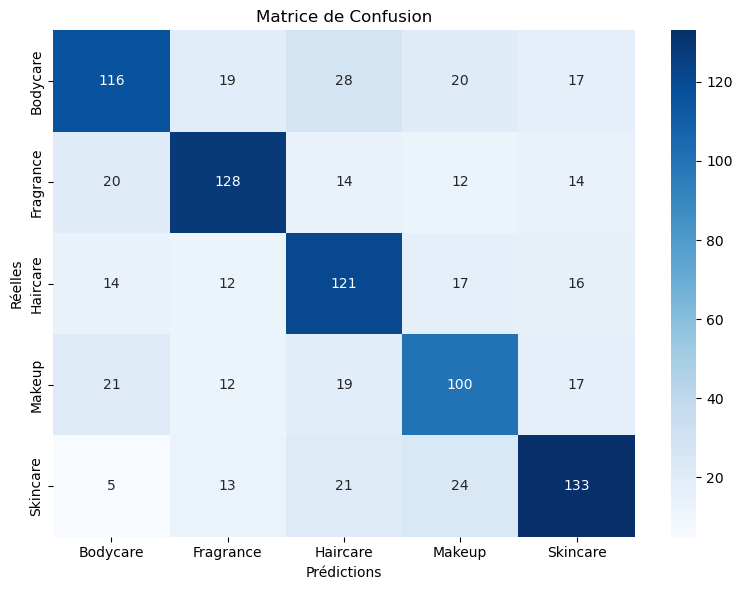

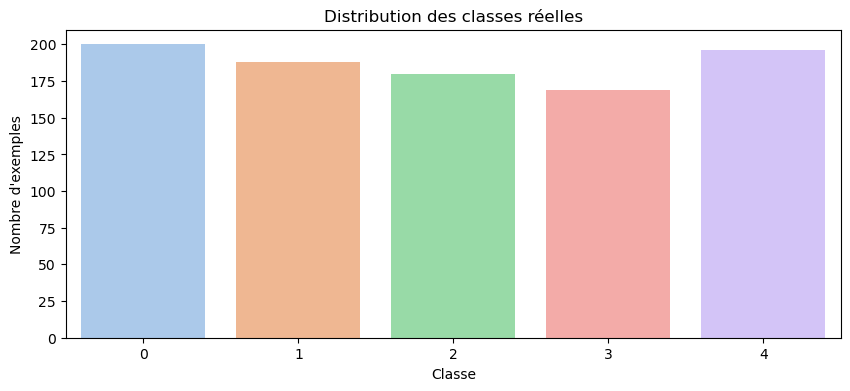

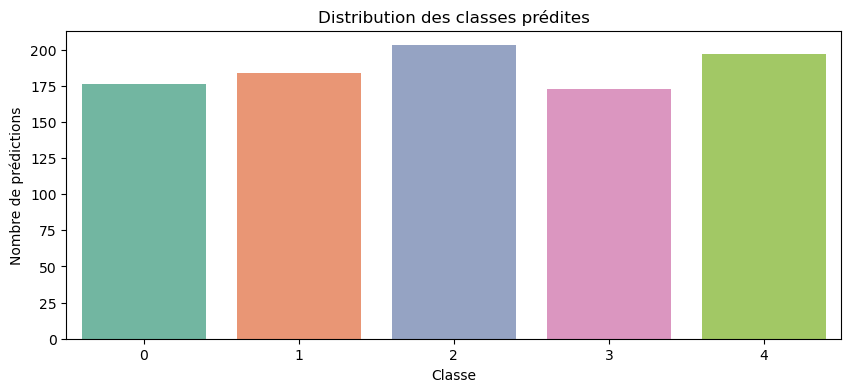

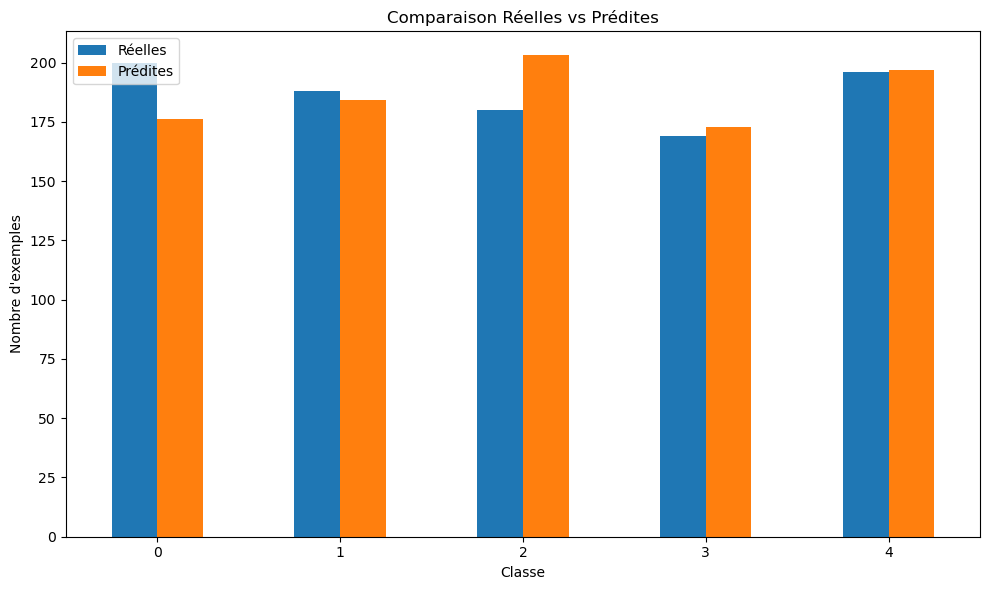

In [4]:
# Imports nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pyodbc 
import warnings
warnings.filterwarnings("ignore")

# --------------------
# 1. Connexion SQL Server
# --------------------
server = 'DESKTOP-OQHAOET'
database = 'DW_supplyChain'
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(conn_str)

# 2. Charger les données
query = """
SELECT 
    productREF,
    productname,
    brandname,
    unitprice,
    materialname,
    materialcategory,
    quantityused,
    manufacturedate,
    expirydate,
    category
FROM Dim_Product
"""
df = pd.read_sql(query, conn)

# 3. Nettoyage et transformation
df['manufacturedate'] = pd.to_datetime(df['manufacturedate'])
df['expirydate'] = pd.to_datetime(df['expirydate'])
df['product_lifetime_days'] = (df['expirydate'] - df['manufacturedate']).dt.days

# 🔧 Conversion de quantityused en numérique
df['quantityused'] = pd.to_numeric(df['quantityused'], errors='coerce')
df['quantityused'].fillna(df['quantityused'].median(), inplace=True)





# 4. Sélectionner les features utiles
features = ['productREF', 'productname', 'brandname', 'unitprice',
            'materialname', 'materialcategory', 'quantityused', 'product_lifetime_days']
X = df[features]
y = df['category']

# 5. Encoder les colonnes catégorielles
label_encoders = {}
for col in ['productREF', 'productname', 'brandname', 'materialname', 'materialcategory']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# 6. Encoder y
le_category = LabelEncoder()
y_encoded = le_category.fit_transform(y)

# 7. Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 8. SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 9. Standardisation des données
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 10. GridSearchCV pour trouver les meilleurs paramètres KNN
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_resampled_scaled, y_resampled)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure précision CV :", grid.best_score_)

# 11. Entraînement du meilleur modèle
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# 12. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_category.classes_))

# 13. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.tight_layout()
plt.show()

# 14. Distribution des classes réelles et prédites
plt.figure(figsize=(10, 4))
sns.countplot(x=y_test, palette='pastel')
plt.title("Distribution des classes réelles")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x=y_pred, palette='Set2')
plt.title("Distribution des classes prédites")
plt.xlabel("Classe")
plt.ylabel("Nombre de prédictions")
plt.show()

# 15. Comparaison Réelles vs Prédites
real_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()
comparison_df = pd.DataFrame({'Réelles': real_counts, 'Prédites': pred_counts})
comparison_df.plot(kind='bar', figsize=(10,6))
plt.title("Comparaison Réelles vs Prédites")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


X_train shape: (3732, 8)
X_test shape: (933, 8)
y_train shape: (3732,)
y_test shape: (933,)
Scores de validation croisée : [0.8017149  0.84137192 0.88424437 0.86387996 0.77491961]
Précision moyenne de la validation croisée : 0.8332
Accuracy: 0.9625

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       202
           1       0.98      0.89      0.94       190
           2       0.99      0.97      0.98       178
           3       0.95      1.00      0.97       174
           4       0.99      0.99      0.99       189

    accuracy                           0.96       933
   macro avg       0.96      0.96      0.96       933
weighted avg       0.96      0.96      0.96       933



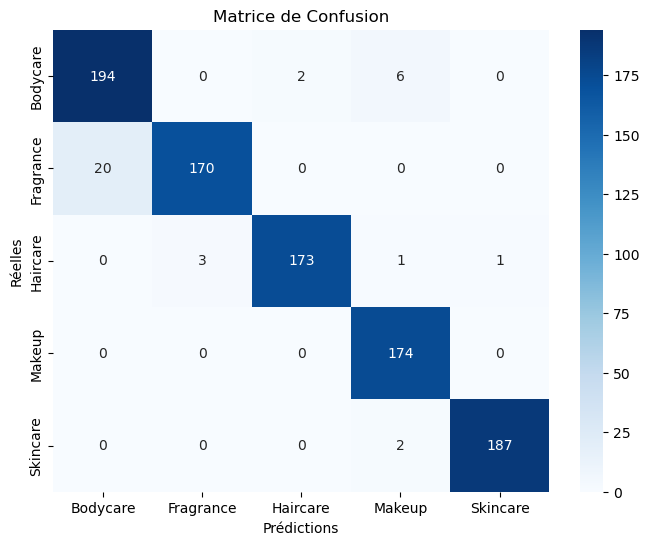

Rapport de Classification:

              precision    recall  f1-score   support

    Bodycare       0.91      0.96      0.93       202
   Fragrance       0.98      0.89      0.94       190
    Haircare       0.99      0.97      0.98       178
      Makeup       0.95      1.00      0.97       174
    Skincare       0.99      0.99      0.99       189

    accuracy                           0.96       933
   macro avg       0.96      0.96      0.96       933
weighted avg       0.96      0.96      0.96       933



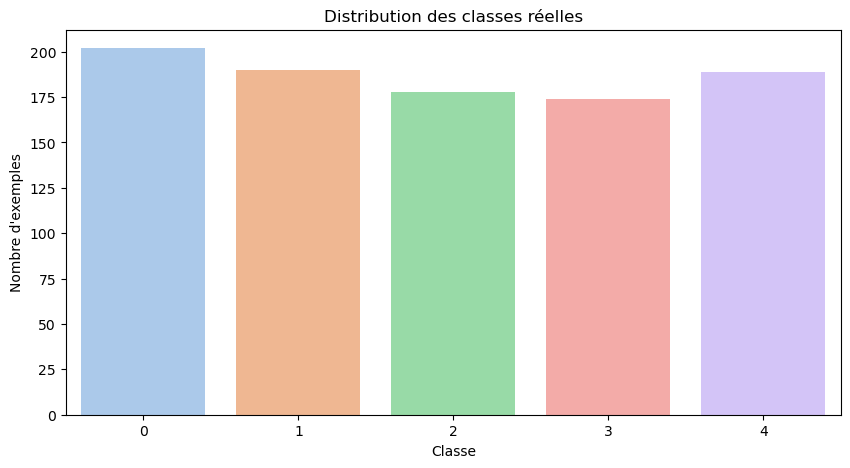

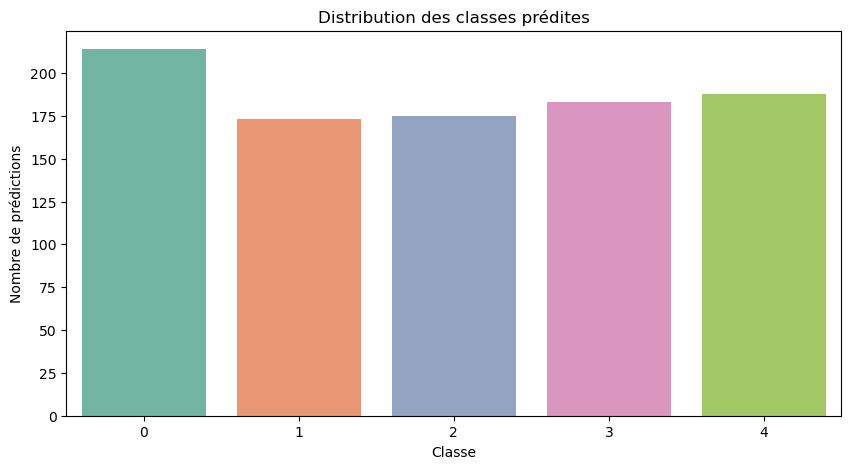

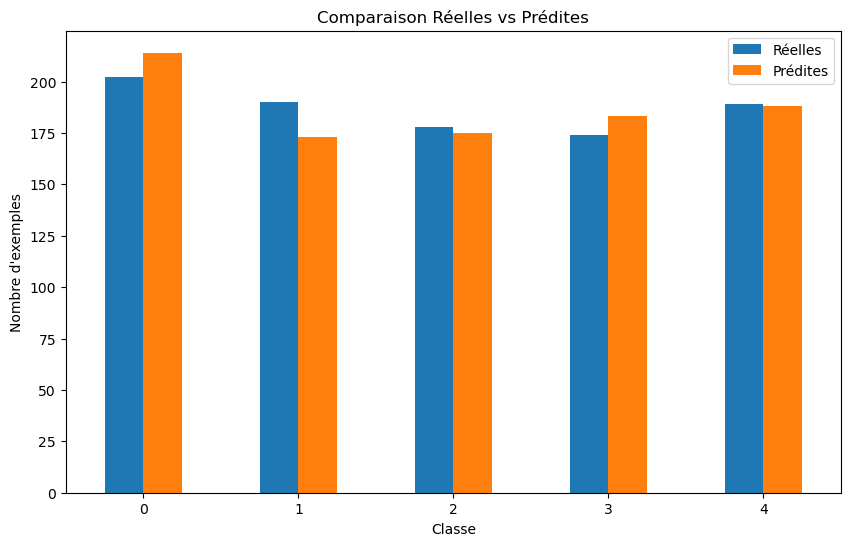

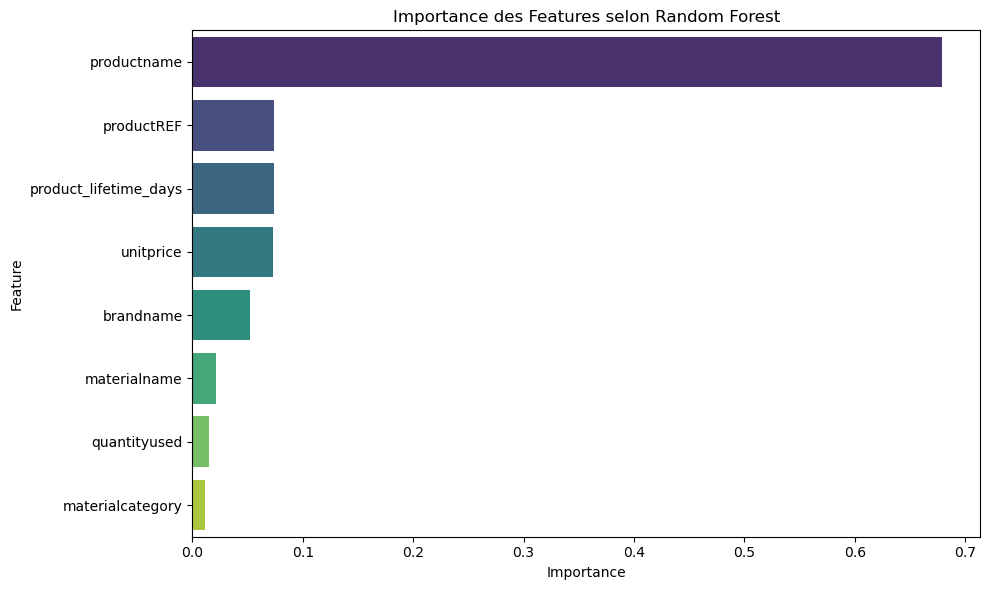

In [5]:
# Imports nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pyodbc 
import warnings
warnings.filterwarnings("ignore")

# --------------------
# 1. Connexion SQL Server
# --------------------
server = 'DESKTOP-OQHAOET'
database = 'DW_supplyChain'
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(conn_str)

# 2. Charger les données
query = """
SELECT 
    productREF,
    productname,
    brandname,
    unitprice,
    materialname,
    materialcategory,
    quantityused,
    manufacturedate,
    expirydate,
    category
FROM Dim_Product
"""
df = pd.read_sql(query, conn)

# 3. Nettoyage et transformation
df['manufacturedate'] = pd.to_datetime(df['manufacturedate'])
df['expirydate'] = pd.to_datetime(df['expirydate'])
df['product_lifetime_days'] = (df['expirydate'] - df['manufacturedate']).dt.days

# 🔧 Conversion de quantityused en numérique
df['quantityused'] = pd.to_numeric(df['quantityused'], errors='coerce')
df['quantityused'].fillna(df['quantityused'].median(), inplace=True)






# 4. Sélectionner les features utiles
features = ['productREF', 'productname', 'brandname', 'unitprice',
            'materialname', 'materialcategory', 'quantityused', 'product_lifetime_days']
X = df[features]
y = df['category']

# 5. Encoder les colonnes catégorielles
label_encoders = {}
for col in ['productREF', 'productname', 'brandname', 'materialname', 'materialcategory']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# 6. Encoder y
le_category = LabelEncoder()
y_encoded = le_category.fit_transform(y)

# 7. Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# 8. Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. Validation croisée avec RandomForest
cv_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(cv_model, X_scaled, y_encoded, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Précision moyenne de la validation croisée : {cv_scores.mean():.4f}")

# 10. Entraînement du modèle final
model = RandomForestClassifier(random_state=42,
                               n_estimators=200,
                               max_depth=15,
                               class_weight='balanced',
                               min_samples_split=20,
                               min_samples_leaf=10,
                               max_features='sqrt',
                               n_jobs=-1)
model.fit(X_train, y_train)

# 11. Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 12. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.show()

# 13. Rapport final avec noms de classes
report = classification_report(y_test, y_pred, target_names=le_category.classes_)
print("Rapport de Classification:\n")
print(report)

# 14. Distribution des classes réelles et prédites
plt.figure(figsize=(10, 5))
sns.countplot(x=y_test, palette='pastel')
plt.title("Distribution des classes réelles")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=y_pred, palette='Set2')
plt.title("Distribution des classes prédites")
plt.xlabel("Classe")
plt.ylabel("Nombre de prédictions")
plt.show()

# 15. Comparaison entre classes réelles et prédites
real_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()
comparison_df = pd.DataFrame({'Réelles': real_counts, 'Prédites': pred_counts})
comparison_df.plot(kind='bar', figsize=(10,6))
plt.title("Comparaison Réelles vs Prédites")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=0)
plt.show()

# 16. Importances des variables
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Importance des Features selon Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


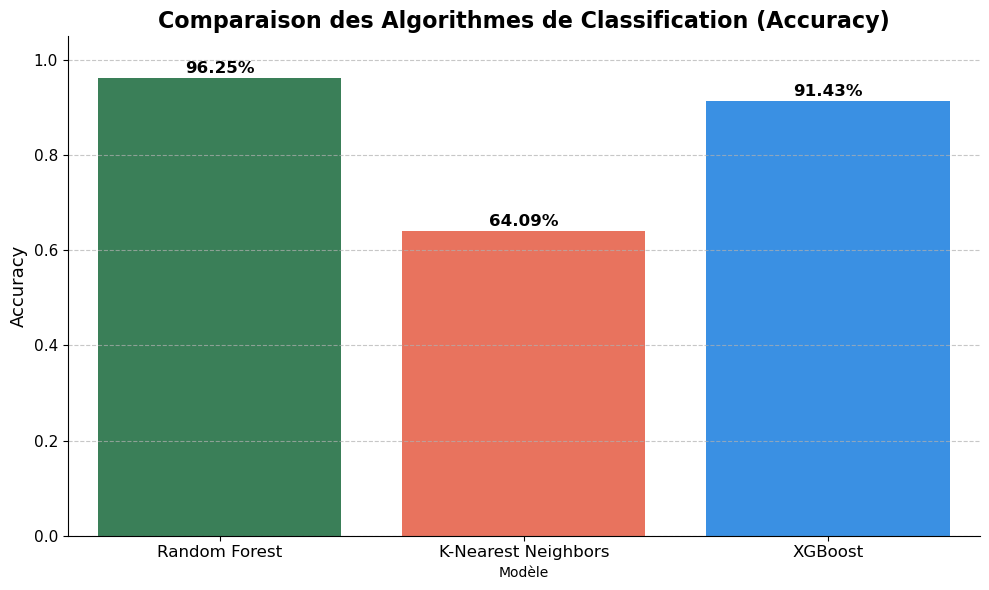


 Interprétation analytique :

********* Random Forest (96.25%) ***********
=> Le plus performant. Il gère efficacement les variables complexes, offrant une généralisation solide et une robustesse face au surapprentissage.
********* XGBoost (91.43%)***********
=> Très compétitif, notamment sur les données tabulaires. Moins performant ici, mais souvent meilleur en optimisant davantage les hyperparamètres.
********* K-Nearest Neighbors (64.09%) ***********
=> Faible performance. Sensible aux dimensions élevées, au bruit, et à l’échelle des données. À éviter pour ce cas d’usage.



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Les accuracies des modèles
data = {
    'Modèle': ['Random Forest', 'K-Nearest Neighbors', 'XGBoost'],
    'Accuracy': [0.9625, 0.6409, 0.9143]
}

df_accuracy = pd.DataFrame(data)

# Palette de couleurs personnalisée
colors = ['#2E8B57', '#FF6347', '#1E90FF']  # Vert, rouge, bleu

# Créer un barplot sophistiqué
plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='Accuracy', data=df_accuracy, palette=colors)

# Ajouter des annotations sur chaque barre
for i, acc in enumerate(df_accuracy['Accuracy']):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha='center', fontsize=12, weight='bold')

# Style pro
plt.title('Comparaison des Algorithmes de Classification (Accuracy)', fontsize=16, weight='bold')
plt.ylabel('Accuracy', fontsize=13)
plt.ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
sns.despine()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Interprétation textuelle à afficher dans la console
print("\n Interprétation analytique :\n")
print("********* Random Forest (96.25%) ***********\n=> Le plus performant. Il gère efficacement les variables complexes, "
      "offrant une généralisation solide et une robustesse face au surapprentissage.")
print("********* XGBoost (91.43%)***********\n=> Très compétitif, notamment sur les données tabulaires. Moins performant ici, "
      "mais souvent meilleur en optimisant davantage les hyperparamètres.")
print("********* K-Nearest Neighbors (64.09%) ***********\n=> Faible performance. Sensible aux dimensions élevées, au bruit, "
      "et à l’échelle des données. À éviter pour ce cas d’usage.\n")


In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pyodbc 
import warnings
warnings.filterwarnings("ignore")

# --------------------
# 1. Connexion SQL Server
# --------------------
server = 'DESKTOP-OQHAOET'
database = 'DW_supplyChain'
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(conn_str)

# 2. Charger les données
query = """
SELECT 
    productREF,
    productname,
    brandname,
    unitprice,
    materialname,
    materialcategory,
    quantityused,
    manufacturedate,
    expirydate,
    category
FROM Dim_Product
"""
df = pd.read_sql(query, conn)

# 3. Nettoyage et transformation
df['manufacturedate'] = pd.to_datetime(df['manufacturedate'])
df['expirydate'] = pd.to_datetime(df['expirydate'])
df['product_lifetime_days'] = (df['expirydate'] - df['manufacturedate']).dt.days

# 🔧 Conversion de quantityused en numérique
df['quantityused'] = pd.to_numeric(df['quantityused'], errors='coerce')
df['quantityused'].fillna(df['quantityused'].median(), inplace=True)







# Features et target
features = ['unitprice', 'quantityused', 'product_lifetime_days', 'brandname', 'materialname', 'materialcategory', 'productname']
target = 'category'
X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['brandname', 'materialname', 'materialcategory', 'productname']),
    ],
    remainder='passthrough'
)

# Pipeline complet
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entraînement
model.fit(X_train, y_train)

# Évaluation
print(f"Score sur le jeu de test : {model.score(X_test, y_test):.2f}")

# ==== SAISIE UTILISATEUR ====

# Entrée utilisateur
print("\n********* Entrez les informations du nouveau produit **********")
unitprice = float(input("Prix unitaire (ex: 102.37): "))
quantityused = int(input("Quantité utilisée (ex: 9): "))
manufacture_date = input("Date de fabrication (YYYY-MM-DD): ")
expiry_date = input("Date de péremption (YYYY-MM-DD): ")
brandname = input("Nom de la marque (ex: Anthony, Colon and Jimenez): ")
materialname = input("Nom du matériau (ex: On): ")
materialcategory = input("Catégorie du matériau (ex: Fragrance): ")
productname = input("Nom du produit (ex: Eau de Toilette 5): ")

# Calcul de la durée de vie
product_lifetime_days = (pd.to_datetime(expiry_date) - pd.to_datetime(manufacture_date)).days

# Création du DataFrame de test
X_new = pd.DataFrame({
    'unitprice': [unitprice],
    'quantityused': [quantityused],
    'product_lifetime_days': [product_lifetime_days],
    'brandname': [brandname],
    'materialname': [materialname],
    'materialcategory': [materialcategory],
    'productname': [productname]
})

# Prédiction
y_pred = model.predict(X_new)

print(f"\n Catégorie prédite pour le produit : {y_pred[0]}")


Score sur le jeu de test : 0.89

********* Entrez les informations du nouveau produit **********


Prix unitaire (ex: 102.37):  79.73
Quantité utilisée (ex: 9):  3
Date de fabrication (YYYY-MM-DD):  2024-11-27
Date de péremption (YYYY-MM-DD):  2025-11-11
Nom de la marque (ex: Anthony, Colon and Jimenez):  Hawkins Ltd
Nom du matériau (ex: On):  Section
Catégorie du matériau (ex: Fragrance):  Essential Oil
Nom du produit (ex: Eau de Toilette 5):  Moisturizer 12



 Catégorie prédite pour le produit : Skincare
